In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from passivbot import *
from vwap import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
user = 'your_user_name_here'
commons, vwap, streamer = prepare_bot('binance', user)
vwap.stop_updater()
commons.stop_call_limiter()


25 / 25 calculating ema for ZEC/BTC ...   
2020-06-25T21:32:40  margin updating balance 
2020-06-25T21:32:41  margin updating my trades ADA/BTC 
2020-06-25T21:32:41  margin updating my trades ATOM/BTC 
2020-06-25T21:32:42  margin updating my trades BAT/BTC 
2020-06-25T21:32:42  margin updating my trades BCH/BTC 
2020-06-25T21:32:42  margin updating my trades BNB/BTC 
2020-06-25T21:32:42  margin updating my trades DASH/BTC 
2020-06-25T21:32:42  margin updating my trades EOS/BTC 
2020-06-25T21:32:42  margin updating my trades ETC/BTC 
2020-06-25T21:32:42  margin updating my trades ETH/BTC 
2020-06-25T21:32:42  margin updating my trades IOST/BTC 
2020-06-25T21:32:43  margin updating my trades IOTA/BTC 
2020-06-25T21:32:43  margin updating my trades LINK/BTC 
2020-06-25T21:32:43  margin updating my trades LTC/BTC 
2020-06-25T21:32:43  margin updating my trades MATIC/BTC 
2020-06-25T21:32:43  margin updating my trades NEO/BTC 
2020-06-25T21:32:43  margin updating my trades ONT/BTC 
2020-06

In [5]:
equities = {}
borrowed = {}
oh = {}
for c in vwap.balance:
    if type(vwap.balance[c]) == int:
        continue
    equities[c] = vwap.balance[c]['equity'] / vwap.balance[c]['account_equity']
    borrowed[c] = vwap.balance[c]['borrowed'] / vwap.balance[c]['account_debt']
    oh[c] = vwap.balance[c]['onhand'] / vwap.balance[c]['account_equity']
print('\n\n(coin equity) divided by (account equity in terms of coin)\n')
for e in sorted(equities.items(), key=lambda x: x[1]):
    print(e)




(coin equity) divided by (account equity in terms of coin)

('BTC', -0.8289879458531199)
('BAT', -0.26357757307702956)
('XMR', -0.18708922609566142)
('ONT', -0.043390648400261606)
('ETH', -0.04208366425789519)
('MATIC', -0.029322702599879135)
('ZEC', -0.018357703036828165)
('IOTA', -0.017787769555506407)
('XTZ', -0.00961006843698764)
('QTUM', -0.009077553549585504)
('IOST', -0.005474373090807565)
('TRX', -0.00544049351242102)
('LINK', -0.002565321692488798)
('VET', 2.142572678581945e-06)
('ETC', 0.00813737464228197)
('ADA', 0.00915596585706829)
('ATOM', 0.01977702047318703)
('BCH', 0.030734163807480962)
('NEO', 0.03512540342704651)
('XLM', 0.03866523099685732)
('DASH', 0.05490756416585524)
('EOS', 0.07631920773232467)
('LTC', 0.11628160684421748)
('RVN', 0.21371187774871797)
('BNB', 0.23570707106530195)
('XRP', 1.6291219117975122)


In [789]:
# uncomment and run this to set emas to current price
'''
tickers = vwap.cc.fetch_tickers()
for sym in vwap.symbols:
    vwap.cm.last_price[sym] = tickers[sym]['last']
    vwap.cm.min_ema[sym] = tickers[sym]['last']   
    vwap.cm.max_ema[sym] = tickers[sym]['last']   
'''

In [6]:
print('n days trade history in memory\n')
rm_ = [((vwap.my_trades[s][-1]['timestamp'] - vwap.my_trades[s][0]['timestamp']) / 1000 / 60 / 60 / 24, s) for s in vwap.symbols]
for e in sorted(rm_):
    print(f"{e[1]:13} {e[0]:.2f}")

n days trade history in memory

NEO/BTC       1.12
XTZ/BTC       1.13
BCH/BTC       1.74
EOS/BTC       1.92
LTC/BTC       2.18
MATIC/BTC     3.87
XLM/BTC       3.99
DASH/BTC      4.11
BNB/BTC       4.12
XMR/BTC       4.20
ATOM/BTC      4.37
RVN/BTC       4.57
ETC/BTC       4.65
BAT/BTC       8.57
TRX/BTC       13.39
IOST/BTC      13.39
VET/BTC       13.76
LINK/BTC      13.90
ETH/BTC       13.94
QTUM/BTC      13.96
ZEC/BTC       13.97
IOTA/BTC      13.99
ONT/BTC       13.99
XRP/BTC       13.99
ADA/BTC       13.99


In [7]:
# set symbol for analysis
s = 'ADA/BTC'
c, q = s.split('/')

In [8]:
vwap.update_balance()
#vwap.init_my_trades(s)
vwap.update_my_trades(s)
vwap.init_loan_history(c, 'borrow')
vwap.init_loan_history(c, 'repay')

2020-06-25T21:35:16  margin updating balance 
2020-06-25T21:35:17  margin updating my trades ADA/BTC 


In [9]:
vwap.update_open_orders(s)
print(f'\ncurrent open orders for {s}\n')
for my_orders in [vwap.my_bids[s], vwap.my_asks[s]]:
    for o in my_orders:
        print({k: o[k] for k in ['symbol', 'side', 'amount', 'price']})


2020-06-25T21:35:24  margin updating open orders ADA/BTC 

current open orders for ADA/BTC

{'symbol': 'ADA/BTC', 'side': 'sell', 'amount': 49.0, 'price': 8.86e-06}
{'symbol': 'ADA/BTC', 'side': 'sell', 'amount': 776.0, 'price': 8.86e-06}


In [12]:
events = sorted(vwap.my_trades[s] + vwap.borrow_history[c] + vwap.repay_history[c], key=lambda x: x['timestamp'])
do_print = False
n = 50
print(f'most recent {n} events')
for e in events[-n:]:
    line = f"{ts_to_date(e['timestamp'] / 1000)[:19]}  {e['side']:7} {e['amount']:.8f}"
    if 'price' in e:
        do_print = True
        line += f" {e['price']}"
    if do_print:
        print(line)

most recent 50 events
2020-06-25T12:22:26  sell    49.00000000 8.88e-06
2020-06-25T14:05:53  buy     50.00000000 8.84e-06
2020-06-25T14:05:57  repay   1.00000000
2020-06-25T14:05:57  buy     50.00000000 8.84e-06
2020-06-25T14:09:50  buy     50.00000000 8.84e-06
2020-06-25T14:10:05  buy     50.00000000 8.82e-06
2020-06-25T14:10:36  buy     50.00000000 8.83e-06
2020-06-25T14:12:27  buy     50.00000000 8.84e-06
2020-06-25T14:12:48  buy     50.00000000 8.84e-06
2020-06-25T14:14:03  buy     18.00000000 8.84e-06
2020-06-25T14:42:09  sell    318.00000000 8.88e-06
2020-06-25T14:42:09  sell    49.00000000 8.88e-06
2020-06-25T15:05:46  borrow  43.21863176
2020-06-25T15:07:48  repay   43.21863176
2020-06-25T15:19:15  borrow  49.00000000
2020-06-25T15:29:24  sell    49.00000000 8.89e-06
2020-06-25T16:12:26  borrow  49.00000000
2020-06-25T16:12:58  sell    49.00000000 8.88e-06
2020-06-25T16:30:27  borrow  22.14042697
2020-06-25T16:32:28  repay   22.14042697
2020-06-25T18:15:33  buy     49.00000000 

In [16]:
for s_ in vwap.symbols:
#for s_ in [s]:
    vwap.set_ideal_orders(s_)
vwap.allocate_credit()
for c_ in [c, q]:
    for key in ['free', 'onhand', 'debt', 'borrowable']:
        print(f"{c_} {key:10} {vwap.balance[c_][key]}")
    print()
print('borrow', vwap.ideal_borrow[c])
print('repay ', vwap.ideal_repay[c])
print()
print('ideal orders')
print('long_buy', vwap.ideal_long_buy[s])
print('shrt_sel', vwap.ideal_shrt_sel[s])
print('long_sel', vwap.ideal_long_sel[s])
print('shrt_buy', vwap.ideal_shrt_buy[s])
print()
print('eligible orders')
for order in vwap.eligible_entries + vwap.eligible_exits:
    if order['symbol'] == s:
        print(order)
print()
print('sum sel amounts', vwap.ideal_shrt_sel[s]['amount'] + vwap.ideal_long_sel[s]['amount'])
print('sum onhand', vwap.balance[c]['onhand'] + vwap.ideal_borrow[c])
print()
print('sum buys cost', (vwap.ideal_shrt_buy[s]['amount'] * vwap.ideal_shrt_buy[s]['price'] +
                        vwap.ideal_long_buy[s]['amount'] * vwap.ideal_long_buy[s]['price']))


ADA free       0.0
ADA onhand     825.0
ADA debt       577.815
ADA borrowable 0.0

BTC free       0.000417
BTC onhand     0.38727706
BTC debt       0.58459561
BTC borrowable 0.0

borrow 0.0
repay  0.0

ideal orders
long_buy {'side': 'buy', 'amount': 0.0, 'price': 8.8e-06}
shrt_sel {'side': 'sell', 'amount': 49.0, 'price': 8.86e-06}
long_sel {'side': 'sell', 'amount': 10153.0, 'price': 8.86e-06}
shrt_buy {'side': 'buy', 'amount': 4757.0, 'price': 8.69e-06}

eligible orders
{'symbol': 'ADA/BTC', 'side': 'sell', 'amount': 49.0, 'price': 8.86e-06}
{'symbol': 'ADA/BTC', 'side': 'sell', 'amount': 776.0, 'price': 8.86e-06}

sum sel amounts 10202.0
sum onhand 825.0

sum buys cost 0.04133833


In [17]:
# true size of positions
vwap.my_trades_analyses[s]

{'true_long_amount': 10153.0,
 'true_long_cost': 0.0856725299999999,
 'true_long_vwap': 8.43814931547325e-06,
 'true_shrt_amount': 4757.0,
 'true_shrt_cost': 0.04147121999999994,
 'true_shrt_vwap': 8.717935673743944e-06,
 'long_start_ts': 0,
 'shrt_start_ts': 1592837225584,
 'small_big_amount_threshold': 105.0,
 'long_cost_vol': 0.0032188399999999993,
 'shrt_cost_vol': 0.0,
 'long_sel_price': 8.46e-06,
 'shrt_buy_price': 8.69e-06}

In [22]:
# speed limit of entries
age_limit_millis = vwap.cc.milliseconds() - vwap.hyperparams['millis_rolling_small_trade_window']
n_hours = vwap.hyperparams['hours_rolling_small_trade_window']
print(f'btc cost limit per {n_hours} hours', vwap.balance[q]['account_equity'] * vwap.hyperparams['account_equity_pct_per_period'])
long_vol_, shrt_vol_ = \
    calc_rolling_cost_vol(vwap.my_trades[s],
                          vwap.my_trades_analyses[s]['small_big_amount_threshold'],
                          age_limit_millis)
print(f'btc cost long last {n_hours} hours', round(long_vol_, 8))
print(f'btc cost shrt last {n_hours} hours', round(shrt_vol_, 8))
print('\ndefault btc cost per entry:')
print(f"{vwap.hyperparams['account_equity_pct_per_trade'] * vwap.balance[q]['account_equity']:.8f}")

btc cost limit per 1.0 hours 0.003213316234964857
btc cost long last 1.0 hours 0.00321884
btc cost shrt last 1.0 hours 0.0

default btc cost per entry:
0.00042844


In [23]:
# dataframe of all trades
n_days = vwap.hyperparams['max_memory_span_days']
mts = vwap.fetch_my_trades(s)
mtdf = pd.DataFrame(mts).set_index('timestamp').drop(['id', 'order_id', 'type'], axis=1)
mtdf = mtdf[mtdf.index > (vwap.cc.milliseconds() - 1000 * 60 * 60 * 24 * n_days)]

105.0


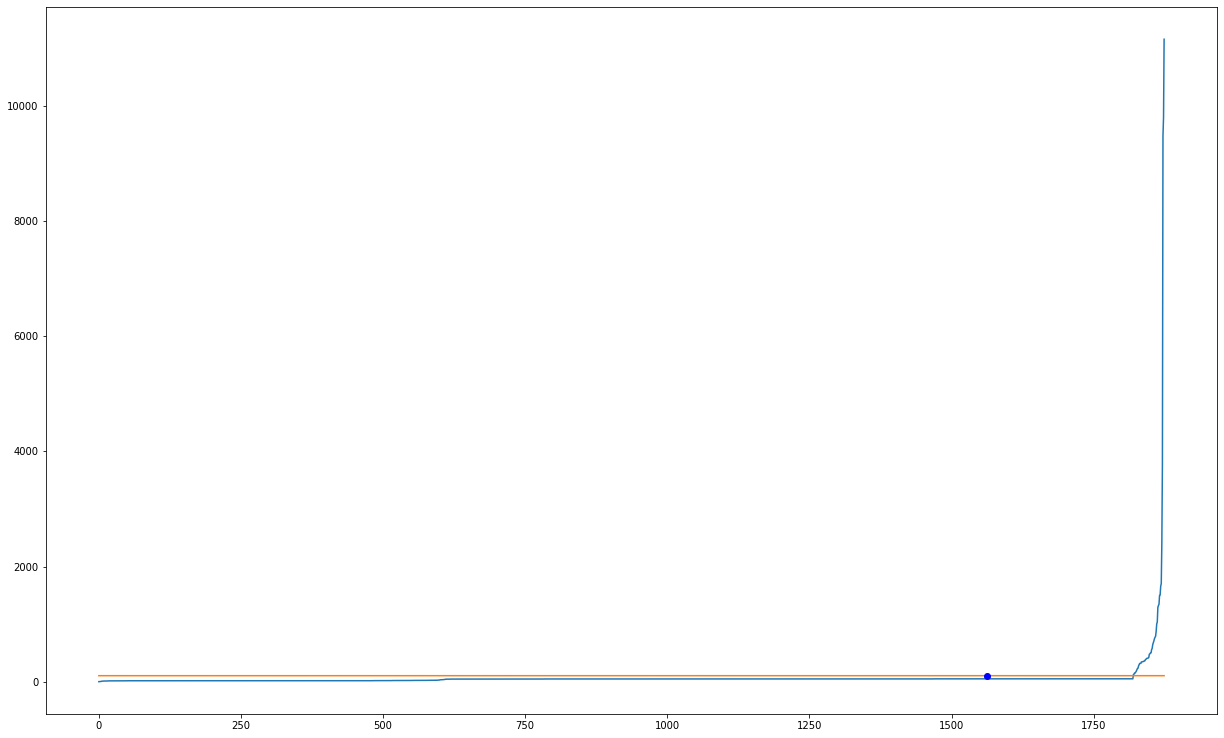

In [24]:
# how the bot determines threshold between entries and exits
amounts = sorted(mtdf.amount.values)
cutoff = 0.83333
threshold = calc_small_big_threshold_amount(vwap.my_trades[s], cutoff=cutoff)
plt.plot(amounts)
plt.plot(np.repeat(threshold, len(amounts)))
plt.plot([int(cutoff * len(amounts))], [threshold], 'bo')
print(threshold)

In [26]:
big_trades = mtdf[mtdf.amount >= threshold]
small_trades = mtdf[mtdf.amount < threshold]
long_buys = small_trades[small_trades.side == 'buy']
shrt_sels = small_trades[small_trades.side == 'sell']
long_sels = big_trades[big_trades.side == 'sell']
shrt_buys = big_trades[big_trades.side == 'buy']

lbc = long_buys.cost.sum()
lba = long_buys.amount.sum()
lsc = long_sels.cost.sum()
lsa = long_sels.amount.sum()

ssc = shrt_sels.cost.sum()
ssa = shrt_sels.amount.sum()
sbc = shrt_buys.cost.sum()
sba = shrt_buys.amount.sum()

print('total quot vol', mtdf.cost.sum())
print('n_days', round((mtdf.index[-1] - mtdf.index[0]) / 1000 / 60 / 60 / 24, 2))
print()

if lba:
    print('long_buy_cost', round(lbc, 8), 'long_buy_vwap', round(lbc / lba, 10))
if lsa:
    print('long_sel_cost', round(lsc, 8), 'long_sel_vwap', round(lsc / lsa, 10))
if lba and lsa:
    print('long_sel_vwap / long_buy_vwap', round((lsc / lsa) / (lbc / lba), 10))

print()

if ssa:
    print('shrt_sel_cost', round(ssc, 8), 'shrt_sel_vwap', round(ssc / ssa, 10))
if sba:
    print('shrt_buy_cost', round(sbc, 8), 'shrt_buy_vwap', round(sbc / sba, 10))
if ssa and sba:
    print('shrt_sel_vwap / shrt_buy_vwap', round((ssc / ssa) / (sbc / sba), 10))

all_buys = mtdf[mtdf.side == 'buy']
all_sels = mtdf[mtdf.side == 'sell']
abc = all_buys.cost.sum()
aba = all_buys.amount.sum()
asc = all_sels.cost.sum()
asa = all_sels.amount.sum()

print()
print('all buy_cost', round(abc, 8), 'buy_vwap', round(abc / aba, 10))
print('all sel_cost', round(asc, 8), 'sel_vwap', round(asc / asa, 10))
print('all sel_vwap / buy_vwap', round((asc / asa) / (abc / aba), 10))

    


total quot vol 1.15752811
n_days 13.99

long_buy_cost 0.33052547 long_buy_vwap 8.5458e-06
long_sel_cost 0.24485294 long_sel_vwap 8.5841e-06
long_sel_vwap / long_buy_vwap 1.0044833543

shrt_sel_cost 0.2679799 shrt_sel_vwap 8.5502e-06
shrt_buy_cost 0.3141698 shrt_buy_vwap 8.4582e-06
shrt_sel_vwap / shrt_buy_vwap 1.0108803382

all buy_cost 0.64469527 buy_vwap 8.5029e-06
all sel_cost 0.51283284 sel_vwap 8.5663e-06
all sel_vwap / buy_vwap 1.0074664927


1.041464140611046
1.1358974358974359


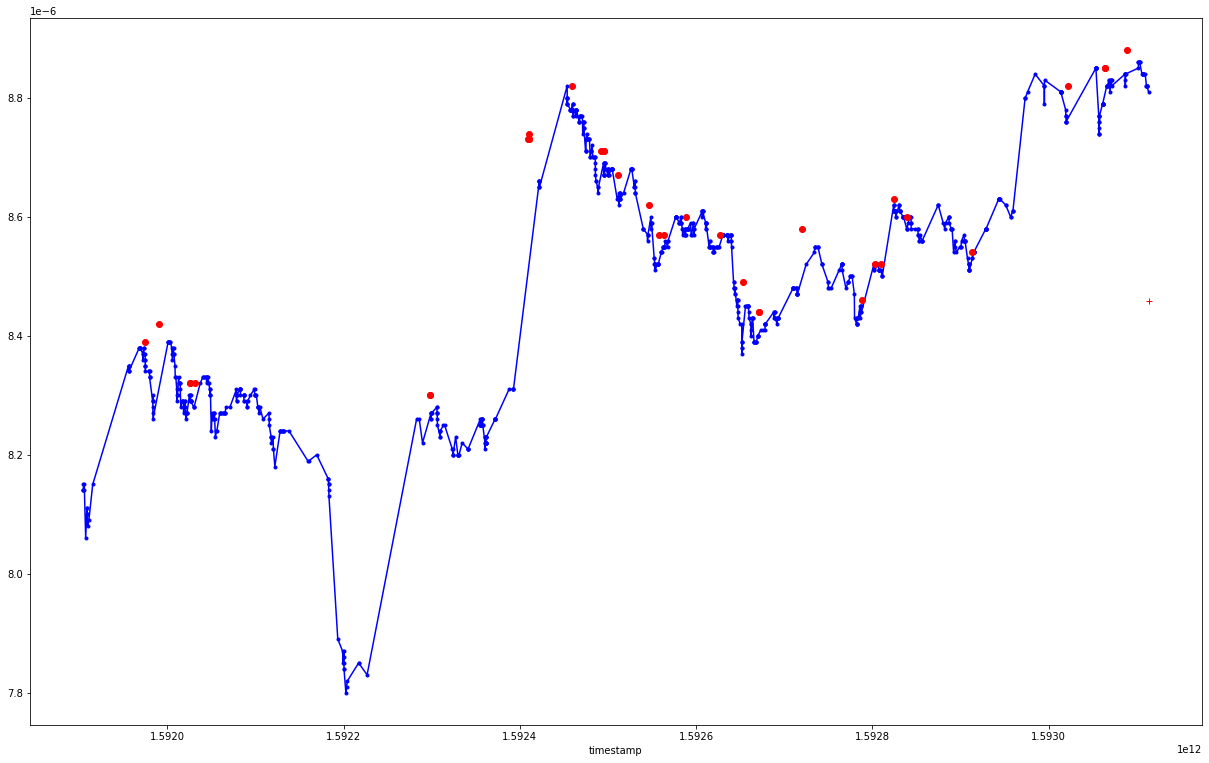

In [27]:
# blue dots are long buys, red dots are long sells, red cross is current long sell price
long_buys.price.plot(style='b.-')
long_sels.price.plot(style='ro')
long_sel_price = vwap.my_trades_analyses[s]['true_long_vwap'] * vwap.hyperparams['profit_pct_plus']
if long_sel_price > 0.0:
    plt.plot([long_buys.index[-1]], [long_sel_price], 'r+')
    print(long_buys.iloc[-1].price / long_sel_price)    
    print(long_buys.price.max() / long_buys.price.min())        

1.021142615895747


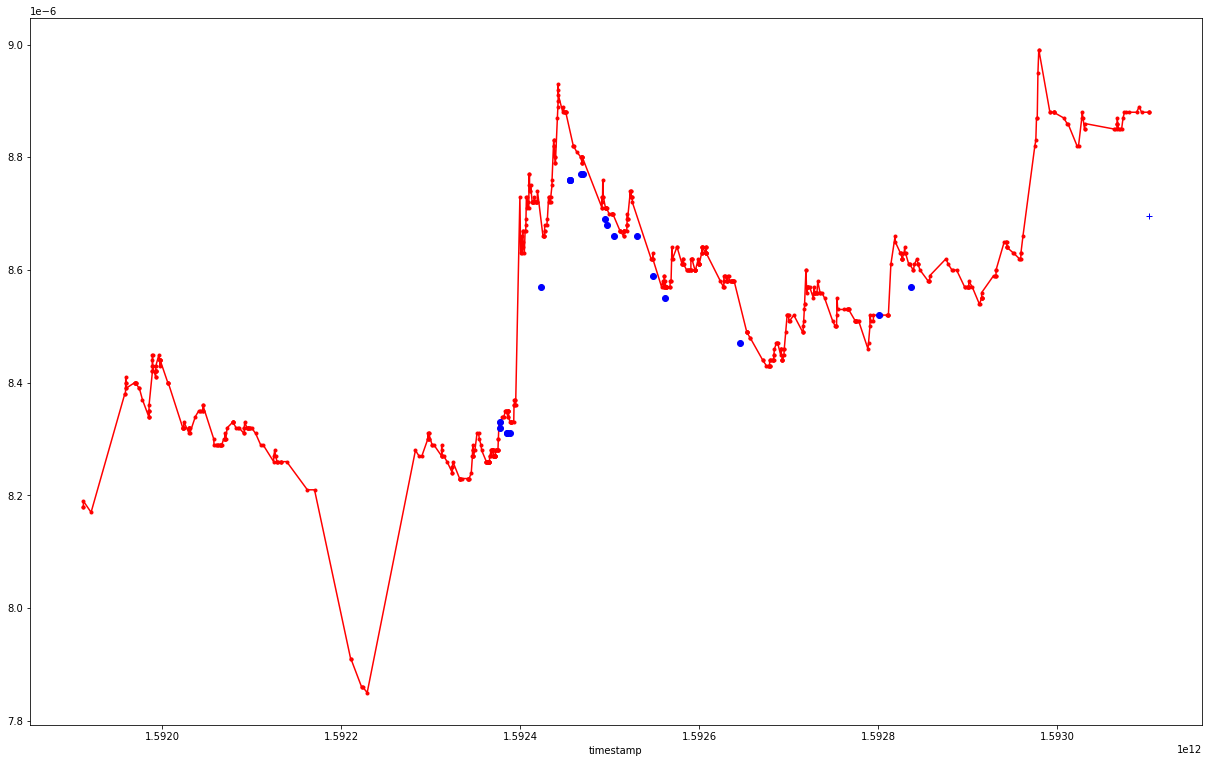

In [28]:
# red dots are short sells, blue dots are short buys, blue cross is current short buy price
shrt_sels.price.plot(style='r.-')
shrt_buys.price.plot(style='bo')
shrt_buy_price = vwap.my_trades_analyses[s]['true_shrt_vwap'] * vwap.hyperparams['profit_pct_minus']
if shrt_buy_price > 0.0:
    plt.plot([shrt_sels.index[-1]], [shrt_buy_price], 'b+')
    print(shrt_sels.iloc[-1].price / shrt_buy_price)

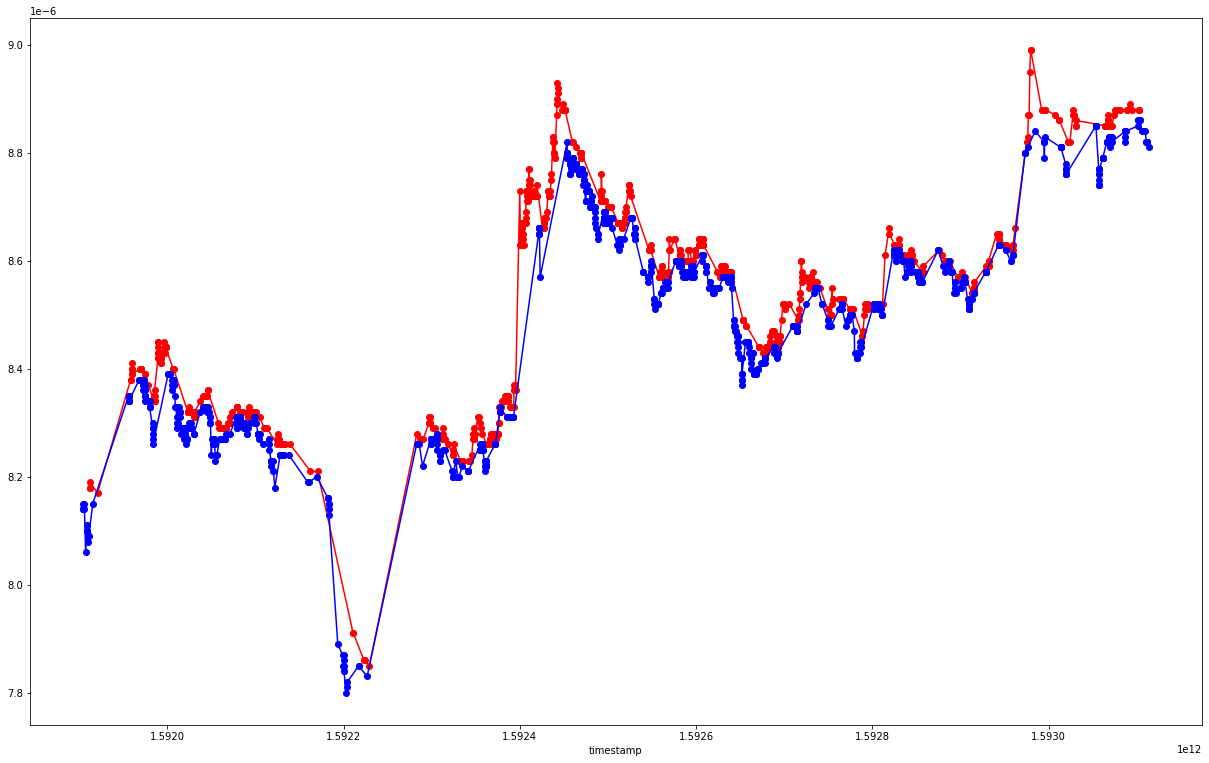

In [29]:
# all buys and sells in one
all_sels.price.plot(style='ro-')
all_buys.price.plot(style='bo-')

In [31]:
tlc = {} # true long costs
tsc = {} # true shrt costs
long_vwaps = {}
shrt_vwaps = {}
for s_ in vwap.my_trades_analyses:
    tlc[s_] = vwap.my_trades_analyses[s_]['true_long_cost']
    tsc[s_] = vwap.my_trades_analyses[s_]['true_shrt_cost']
    long_vwaps[s_] = vwap.my_trades_analyses[s_]['true_long_vwap']
    shrt_vwaps[s_] = vwap.my_trades_analyses[s_]['true_shrt_vwap']
print('exit costs sorted low to high')
for itm in sorted([(e[0], round(e[1], 4)) for e in tlc.items()], key=lambda x: x[1])[-20:]:
    print('true long cost', itm)
print()
for itm in sorted([(e[0], round(e[1], 4)) for e in tsc.items()], key=lambda x: x[1])[-20:]:
    print('true shrt cost', itm)


exit costs sorted low to high
true long cost ('TRX/BTC', 0.02)
true long cost ('EOS/BTC', 0.0222)
true long cost ('IOST/BTC', 0.023)
true long cost ('BNB/BTC', 0.0239)
true long cost ('LTC/BTC', 0.0312)
true long cost ('VET/BTC', 0.0396)
true long cost ('ATOM/BTC', 0.0531)
true long cost ('RVN/BTC', 0.0538)
true long cost ('ETC/BTC', 0.0596)
true long cost ('DASH/BTC', 0.0706)
true long cost ('ONT/BTC', 0.0843)
true long cost ('ADA/BTC', 0.0857)
true long cost ('BAT/BTC', 0.089)
true long cost ('XMR/BTC', 0.0935)
true long cost ('IOTA/BTC', 0.0971)
true long cost ('LINK/BTC', 0.1237)
true long cost ('QTUM/BTC', 0.1655)
true long cost ('ETH/BTC', 0.2556)
true long cost ('ZEC/BTC', 0.2678)
true long cost ('XRP/BTC', 0.394)

true shrt cost ('XTZ/BTC', 0.0013)
true shrt cost ('XLM/BTC', 0.0017)
true shrt cost ('NEO/BTC', 0.0019)
true shrt cost ('MATIC/BTC', 0.0026)
true shrt cost ('RVN/BTC', 0.0026)
true shrt cost ('IOTA/BTC', 0.0042)
true shrt cost ('TRX/BTC', 0.0226)
true shrt cost ('IOS

In [32]:
lst = [(e[0], round(e[1], 8), vwap.cm.last_price[e[0]], vwap.cm.last_price[e[0]] / (e[1] if e[1] else 10e-10)) for e in shrt_vwaps.items()]
print('shrts closest to filling:')
for e in sorted(lst, key=lambda x: x[3]):
    if e[0] not in vwap.do_shrt_buy:
        continue
    
    line = f"{e[0]:<12} true shrt cost: {vwap.my_trades_analyses[e[0]]['true_shrt_cost']:.6f}"
    line += f" true shrt vwap: {e[1]:.8f} last price: {e[2]:.8f}"
    line += f" div {e[3]:.4f}"
    print(line)

    
    

shrts closest to filling:
RVN/BTC      true shrt cost: 0.002586 true shrt vwap: 0.00000219 last price: 0.00000217 div 0.9886
XTZ/BTC      true shrt cost: 0.001300 true shrt vwap: 0.00028323 last price: 0.00028040 div 0.9900
XLM/BTC      true shrt cost: 0.001742 true shrt vwap: 0.00000738 last price: 0.00000732 div 0.9919
NEO/BTC      true shrt cost: 0.001875 true shrt vwap: 0.00112300 last price: 0.00111700 div 0.9947
QTUM/BTC     true shrt cost: 0.000430 true shrt vwap: 0.00018600 last price: 0.00018600 div 1.0000
MATIC/BTC    true shrt cost: 0.002564 true shrt vwap: 0.00000235 last price: 0.00000235 div 1.0007
ETC/BTC      true shrt cost: 0.057002 true shrt vwap: 0.00066350 last price: 0.00066400 div 1.0007
ETH/BTC      true shrt cost: 0.120498 true shrt vwap: 0.02510370 last price: 0.02516000 div 1.0022
XMR/BTC      true shrt cost: 0.096509 true shrt vwap: 0.00693160 last price: 0.00694800 div 1.0024
BNB/BTC      true shrt cost: 0.124714 true shrt vwap: 0.00171428 last price: 0.0017

In [33]:
lst = [(e[0], round(e[1], 8), vwap.cm.last_price[e[0]], e[1] / vwap.cm.last_price[e[0]]) for e in long_vwaps.items()]
print('longs closest to filling:')
for e in sorted(lst, key=lambda x: x[3]):
    if e[0] not in vwap.do_long_sel:
        continue
    
    line = f"{e[0]:<12} true long cost: {vwap.my_trades_analyses[e[0]]['true_long_cost']:.6f}"
    line += f" true long vwap: {e[1]:.8f} last price: {e[2]:.8f}"
    line += f" div {e[3]:.4f}"
    print(line)

    
    

longs closest to filling:
BAT/BTC      true long cost: 0.088991 true long vwap: 0.00002477 last price: 0.00002825 div 0.8767
LINK/BTC     true long cost: 0.123707 true long vwap: 0.00046506 last price: 0.00051267 div 0.9071
ZEC/BTC      true long cost: 0.267817 true long vwap: 0.00553729 last price: 0.00606500 div 0.9130
ONT/BTC      true long cost: 0.084327 true long vwap: 0.00006242 last price: 0.00006830 div 0.9139
VET/BTC      true long cost: 0.039620 true long vwap: 0.00000093 last price: 0.00000098 div 0.9451
IOST/BTC     true long cost: 0.022967 true long vwap: 0.00000065 last price: 0.00000068 div 0.9498
ADA/BTC      true long cost: 0.085673 true long vwap: 0.00000844 last price: 0.00000880 div 0.9589
QTUM/BTC     true long cost: 0.165503 true long vwap: 0.00017839 last price: 0.00018600 div 0.9591
XLM/BTC      true long cost: 0.010942 true long vwap: 0.00000708 last price: 0.00000732 div 0.9675
IOTA/BTC     true long cost: 0.097121 true long vwap: 0.00002331 last price: 0.0000

In [34]:
# past 24h vol per symbol
age_limit = vwap.cc.milliseconds() - 1000 * 60 * 60 * 24
vols = []
for s_ in vwap.my_trades:
    vols.append((round(sum([e['cost'] for e in vwap.my_trades[s_] if e['timestamp'] > age_limit]), 4), s_))
print(sum([e[0] for e in vols]))
sorted(vols)

2.8818999999999995


[(0.0034, 'IOST/BTC'),
 (0.0061, 'VET/BTC'),
 (0.0097, 'MATIC/BTC'),
 (0.011, 'TRX/BTC'),
 (0.0321, 'RVN/BTC'),
 (0.0344, 'LINK/BTC'),
 (0.0459, 'BAT/BTC'),
 (0.0516, 'ADA/BTC'),
 (0.071, 'DASH/BTC'),
 (0.0714, 'IOTA/BTC'),
 (0.0724, 'ZEC/BTC'),
 (0.0846, 'ONT/BTC'),
 (0.0851, 'XMR/BTC'),
 (0.0867, 'ETC/BTC'),
 (0.0893, 'BNB/BTC'),
 (0.0916, 'LTC/BTC'),
 (0.0963, 'XLM/BTC'),
 (0.1055, 'ATOM/BTC'),
 (0.1188, 'ETH/BTC'),
 (0.137, 'QTUM/BTC'),
 (0.1426, 'BCH/BTC'),
 (0.2133, 'XRP/BTC'),
 (0.2805, 'NEO/BTC'),
 (0.4564, 'XTZ/BTC'),
 (0.4852, 'EOS/BTC')]

In [35]:
# overall performance analysis

In [42]:
r = []
n_days = 30 # set n_days
start_ts = vwap.cc.milliseconds() - 1000 * 60 * 60 * 24 * n_days
for s_ in sorted(vwap.my_trades):
    sys.stdout.write(f'\r{s_}  ')
    sys.stdout.flush()
    mt = vwap.fetch_my_trades(s_)
    mtdf = pd.DataFrame(mt).set_index('timestamp')
    mtdf = mtdf[mtdf.index > start_ts]
    actual_n_days = (mtdf.index[-1] - mtdf.index[0]) / 1000 / 60 / 60 / 24
    buys = mtdf[mtdf.side == 'buy']
    sels = mtdf[mtdf.side == 'sell']
    bcost = buys.cost.sum()
    bamount = buys.amount.sum()
    bvwap = bcost / bamount
    scost = sels.cost.sum()
    samount = sels.amount.sum()
    svwap = scost / samount
    div_ = svwap / bvwap
    r.append({'bcost': bcost, 'scost': scost, 'svwap_bvwap': div_, 'actual_n_days': actual_n_days,
              'symbol': s_, 'cost': scost + bcost})

ZEC/BTC    

In [43]:
rdf = pd.DataFrame(r)
rdf.loc[:,'vwg'] = rdf.svwap_bvwap * rdf.cost / rdf.cost.sum()
rdf.sort_values('vwg')

,bcost,scost,svwap_bvwap,actual_n_days,symbol,cost,vwg
9,0.042630470,0.043374000,0.9803715689,29.0709218056,IOST/BTC,0.086004470,0.0016464169
19,0.107219770,0.111528520,0.9788607444,29.6821314005,VET/BTC,0.218748290,0.0041811300
18,0.160187430,0.194636670,1.0042446062,29.3315050000,TRX/BTC,0.354824100,0.0069579405
13,0.469515540,0.478013410,1.0049297388,29.8374155324,MATIC/BTC,0.947528950,0.0185932915
17,0.506625690,0.459067270,1.0080684291,29.9379981597,RVN/BTC,0.965692960,0.0190089081
15,0.628165952,0.628367042,1.0049301189,29.8337577894,ONT/BTC,1.256532994,0.0246568647
10,0.852325500,0.855850510,0.9992448112,29.9033912847,IOTA/BTC,1.708176010,0.0333297927
16,0.904806543,0.839202650,1.0167527617,29.8214365741,QTUM/BTC,1.744009193,0.0346251946
0,0.930269680,0.857162700,1.0026540447,29.9891627778,ADA/BTC,1.787432380,0.0349952277
20,0.921612820,0.919738570,1.0038925321,29.9979091435,XLM/BTC,1.841351390,0.0360954109


In [44]:
(rdf.svwap_bvwap * rdf.cost / rdf.cost.sum()).sum()

1.0039321820887894

In [ ]:
# view balance logs

In [45]:
with open(f'logs/binance/{user}/balance_margin.txt') as f:
    lines = f.readlines()

In [46]:
bals = sorted([json.loads(line) for line in lines], key=lambda x: x['timestamp'])[2:]
ndays = (bals[-1]['timestamp'] - bals[0]['timestamp']) / 1000 / 60 / 60 / 24
print('n_days', ndays)

ndays 24.445275717592594


In [47]:
len(bals)

579

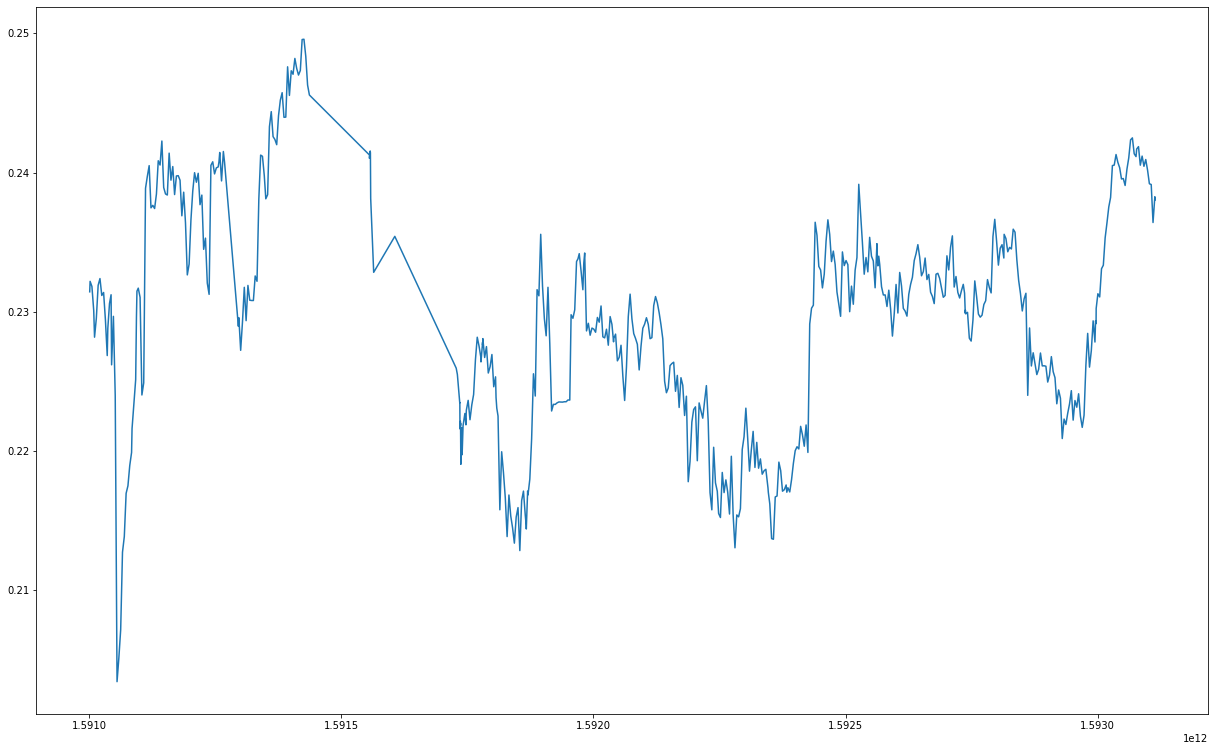

In [48]:
plt.plot([b['timestamp'] for b in bals], [b['BTC']['account_equity'] for b in bals])

In [50]:
print('average daily gain')
(bals[-1]['BTC']['account_equity'] / bals[0]['BTC']['account_equity'])**(1 / ndays)

average daily gain


1.0011502954303357

In [37]:
'''
p * adg**ndays = r
adg**ndays = r / p
adg = (r / p)**(1 / ndays)
'''

'\np * adg**ndays = r\nadg**ndays = r / p\nadg = (r / p)**(1 / ndays)\n'

In [51]:
# here follows a simple backtester

In [52]:
import trade_data

In [53]:
s_ = 'XMR/BTC'
n_days = 180
ohlcv = trade_data.fetch_ohlcvs(s_, n_days)

fetched 1m ohlcvs for XMR/BTC 2020-06-25T05:09:00
fetched 1m ohlcvs for XMR/BTC 2020-06-24T12:30:00
fetched 1m ohlcvs for XMR/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for XMR/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for XMR/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for XMR/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for XMR/BTC 2019-11-30T08:20:00
2020-06-25T21:48:40  2019-11.csv already present, merging... 
2020-06-25T21:48:41  2020-02.csv already present, merging... 
2020-06-25T21:48:42  2020-03.csv already present, merging... 
2020-06-25T21:48:42  2020-04.csv already present, merging... 
2020-06-25T21:48:43  2020-06.csv already present, merging... 


In [54]:
ema_spans = vwap.hyperparams['ema_spans_minutes']
print(ema_spans)
ema_spans = [10, 60 * 3]
ns = np.array([1.6**i for i in range(10)])
ns = ns / ns.max() * 60 * 18
ema_spans = [int(e) for e in ns]
print(ema_spans)


[15, 25, 40, 64, 102, 164, 263, 421, 675, 1080]
[15, 25, 40, 64, 102, 164, 263, 421, 675, 1080]


In [55]:
emas = []
for span in ema_spans:
    ema = ohlcv.close.ewm(span=span, adjust=False).mean()
    ema.name = str(span)
    emas.append(ema)


In [56]:
minema = pd.concat(emas, axis=1).min(axis=1)
minema.name = 'min_ema'
maxema = pd.concat(emas, axis=1).max(axis=1)
maxema.name = 'max_ema'

In [57]:
df = ohlcv.join(minema).join(maxema)
print(len(df))

298577


1.009783851889769


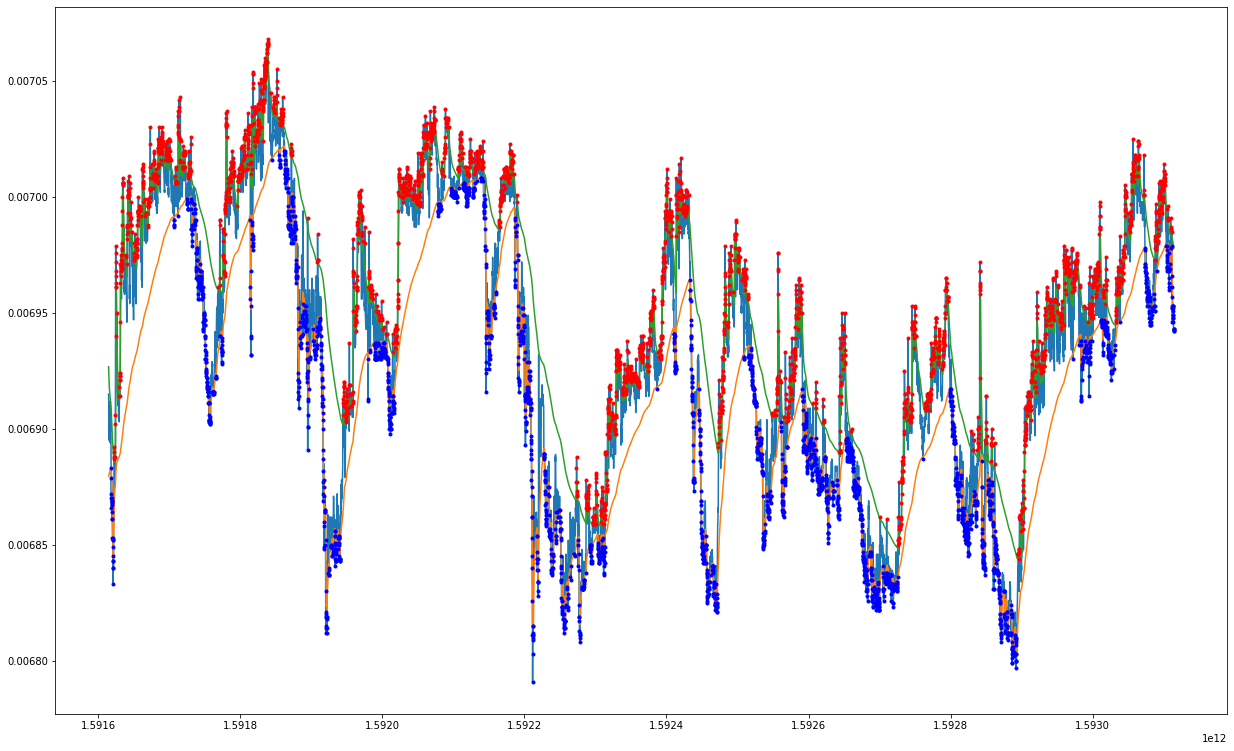

In [58]:
dfc = df[['close', 'min_ema', 'max_ema']].iloc[-25000::2]
dfcb = dfc[dfc.close <= dfc.min_ema]
dfcs = dfc[dfc.close >= dfc.max_ema]
print(dfcs.close.mean() / dfcb.close.mean())
plt.plot(dfc)
plt.plot(dfcb.close, 'b.')
plt.plot(dfcs.close, 'r.')

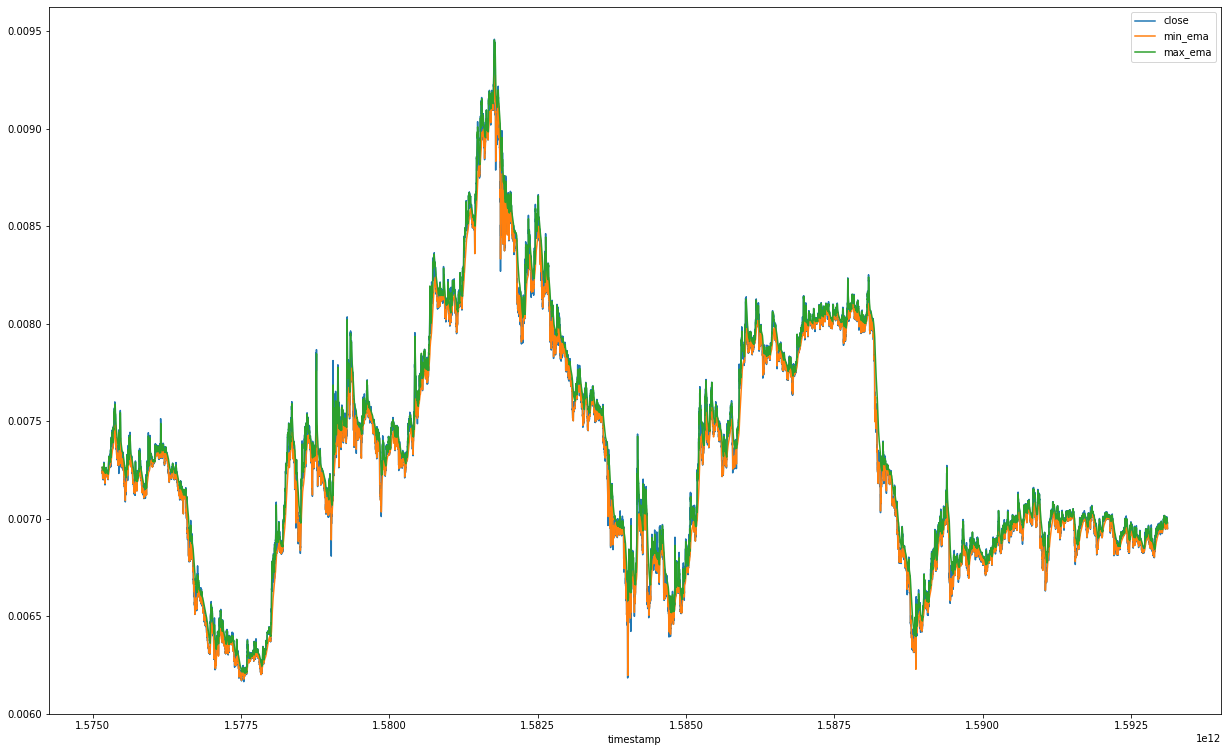

In [59]:
df[['close', 'min_ema', 'max_ema']].iloc[::10].plot()

In [60]:
long_cost = 0.0
long_amount = 0.0
shrt_cost = 0.0
shrt_amount = 0.0

profit = 1.0025
default_trade_cost = 0.0001
min_big_trade_size = default_trade_cost * 6

long_sel_price = 9e9
shrt_buy_price = 0.0

long_sels = []
shrt_buys = []

long_buys = []
shrt_sels = []

long_sel_prices = []
shrt_buy_prices = []

biggest_long_cost = 0.0
biggest_shrt_cost = 0.0

prev_row = next(df.itertuples())


for row in df.itertuples():
    if long_amount > min_big_trade_size and row.high >= long_sel_price:
        biggest_long_cost = max(biggest_long_cost, long_cost)
        long_sels.append({'price': max(long_sel_price, prev_row.close), 'amount': long_amount, 'timestamp': row.Index})
        long_cost = 0.0
        long_amount = 0.0
        long_sel_price = 9e9
    elif row.low <= row.min_ema:
        long_buy_price = min(row.min_ema, prev_row.close)
        long_buy_amount = default_trade_cost / long_buy_price
        long_buys.append({'price': long_buy_price, 'amount': long_buy_amount, 'timestamp': row.Index})
        long_cost += default_trade_cost
        long_amount += long_buy_amount
        long_sel_price = (long_cost / long_amount) * profit
        long_sel_prices.append({'timestamp': row.Index, 'long_sel_price': long_sel_price})
    
    if shrt_amount > min_big_trade_size and row.low <= shrt_buy_price:
        biggest_shrt_cost = max(biggest_shrt_cost, shrt_cost)
        
        shrt_buys.append({'price': min(shrt_buy_price, prev_row.close), 'amount': shrt_amount, 'timestamp': row.Index})
        shrt_cost = 0.0
        shrt_amount = 0.0
        shrt_buy_price = 0.0
    elif row.high >= row.max_ema:
        shrt_sel_price = max(row.max_ema, prev_row.close)
        shrt_sel_amount = default_trade_cost / shrt_sel_price
        shrt_sels.append({'price': shrt_sel_price, 'amount': shrt_sel_amount, 'timestamp': row.Index})
        shrt_cost += default_trade_cost
        shrt_amount += shrt_sel_amount
        shrt_buy_price = (shrt_cost / shrt_amount) / profit
        shrt_buy_prices.append({'timestamp': row.Index, 'shrt_buy_price': shrt_buy_price})
    prev_row = row
biggest_long_cost, biggest_shrt_cost

(0.6219999999999478, 0.4424999999999676)

In [63]:
print('10 longest bag durations days:\n')
for e in sorted(np.diff([e['timestamp'] / 1000 / 60 / 60 / 24 for e in long_sels + [{'timestamp': df.index[-1]}]]))[-10:]:
    print('long', round(e, 4))
print()
for e in sorted(np.diff([e['timestamp'] / 1000 / 60 / 60 / 24 for e in shrt_buys + [{'timestamp': df.index[-1]}]]))[-10:]:
    print('shrt', round(e, 4))
print()
print('longest duration hours between entries:')
for e in sorted(np.diff([e['timestamp'] / 1000 / 60 / 60 for e in long_buys]))[-20:]:
    print('long entry', round(e, 4))
print()
for e in sorted(np.diff([e['timestamp'] / 1000 / 60 / 60 for e in shrt_sels]))[-20:]:
    print('shrt entry', round(e, 4))

10 longest bag durations days:

long 1.1042
long 1.2236
long 1.2271
long 1.2819
long 1.3049
long 1.3972
long 1.4465
long 1.4576
long 1.7556
long 12.0021

shrt 1.0979
shrt 1.1312
shrt 1.1507
shrt 1.4806
shrt 1.6535
shrt 1.7639
shrt 2.4264
shrt 3.9382
shrt 4.9979
shrt 7.1056

longest duration hours between entries:
long entry 18.1
long entry 18.2833
long entry 19.5333
long entry 20.4167
long entry 20.4167
long entry 21.0833
long entry 21.85
long entry 21.85
long entry 23.1
long entry 23.4
long entry 23.7667
long entry 26.05
long entry 27.3333
long entry 28.2333
long entry 28.4833
long entry 29.95
long entry 31.2667
long entry 33.0833
long entry 33.5
long entry 40.8833

shrt entry 15.9333
shrt entry 16.7667
shrt entry 16.8833
shrt entry 17.2333
shrt entry 17.2333
shrt entry 17.3
shrt entry 17.3167
shrt entry 17.4833
shrt entry 17.65
shrt entry 17.6667
shrt entry 18.05
shrt entry 18.5667
shrt entry 18.7
shrt entry 20.1667
shrt entry 20.5333
shrt entry 21.0833
shrt entry 21.1333
shrt entry 

In [64]:
lspdf = pd.DataFrame(long_sel_prices).set_index('timestamp')
sbpdf = pd.DataFrame(shrt_buy_prices).set_index('timestamp')


lbdf = pd.DataFrame(long_buys).set_index('timestamp')
ssdf = pd.DataFrame(shrt_sels).set_index('timestamp')

lsdf = pd.DataFrame(long_sels).set_index('timestamp')
sbdf = pd.DataFrame(shrt_buys).set_index('timestamp')

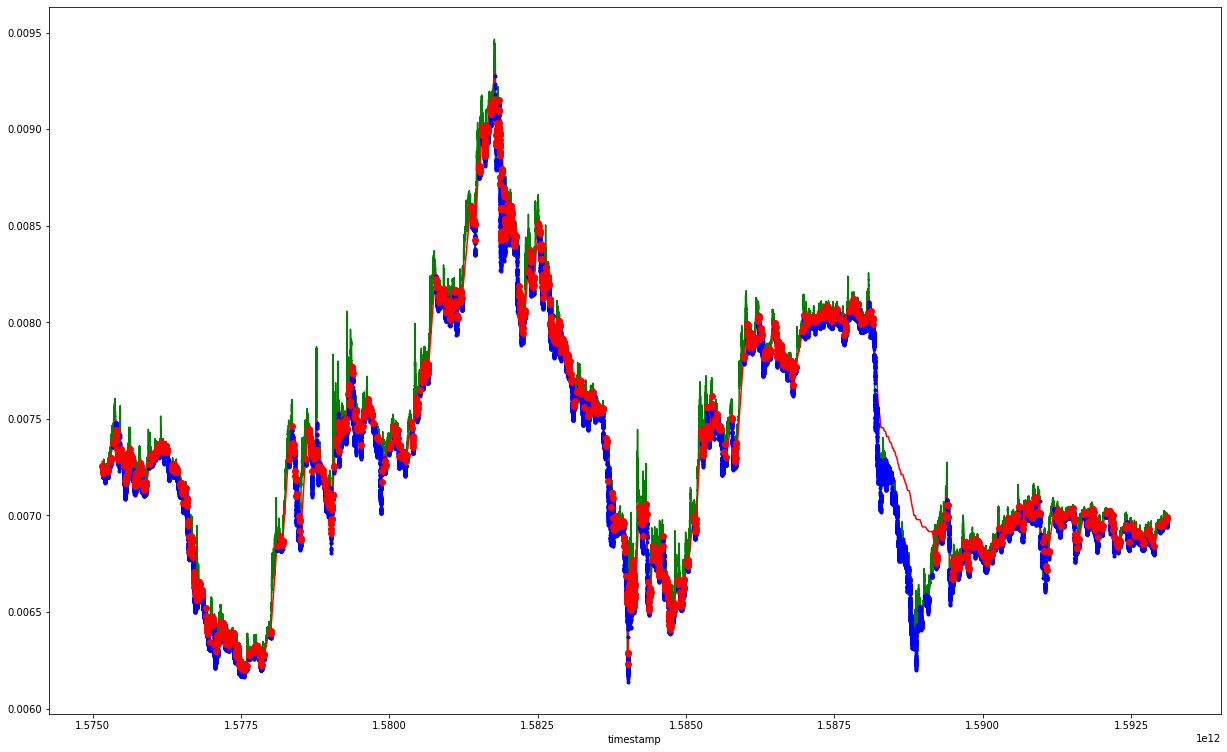

In [65]:
# long
plt.plot(df.close, 'g')
plt.plot(lspdf, 'r-')
lbdf.price.plot(style='b.')
lsdf.price.plot(style='ro')

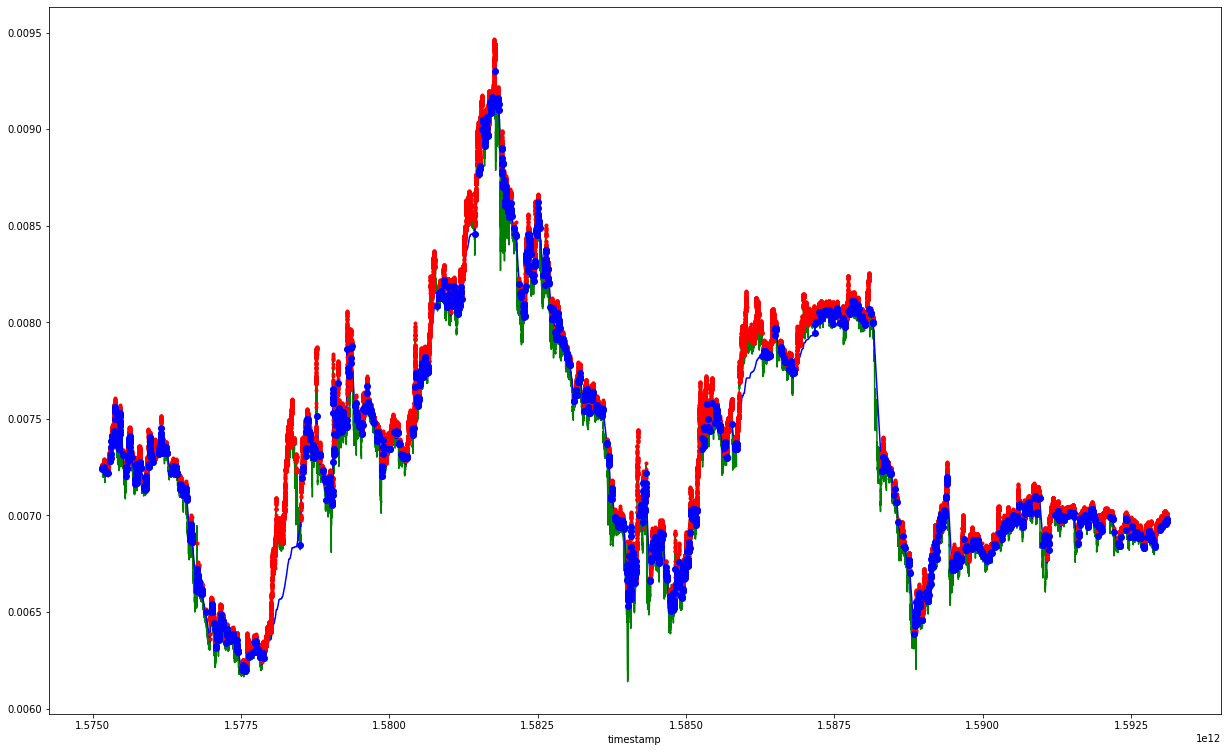

In [66]:
# short
plt.plot(df.close, 'g')
plt.plot(sbpdf, 'b-')
ssdf.price.plot(style='r.')
sbdf.price.plot(style='bo')

In [71]:
lbcost = (lbdf.price * lbdf.amount).sum()
lbamount = lbdf.amount.sum()
sscost = (ssdf.price * ssdf.amount).sum()
ssamount = ssdf.amount.sum()
d = (sscost / ssamount) / (lbcost / lbamount)
vol = (lbcost + sscost)
print('entries only')
print(f'vol: {vol:.2f} svwap/bvwap: {d:.8f} quot profit: {vol * (d - 1):.4f}')

entries only
vol: 18.25 svwap/bvwap: 1.01499972 quot profit: 0.2738
